# 1. Importing Libraries

In [10]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp

# Common Functions
**'g'** - To start collecting frames for the current action and sequence number 

**'h'** - To start collecting frames for the current action and sequence number after a countdown of 3 seconds 

**'c'** - To collect a specific action and sequence number. Starts after a countdown of 3 seconds. After collection is complete, the collection will return to the previous sequences.

In [3]:
actions = np.array(['a','b','c','d','e','f','g','h','i','j']); 

# Change the action name for each new action

# 2. Keypoint extraction using MediaPipe

In [17]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                              )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                              )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                              )
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                              )
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Mirror the frame
        frame = cv2.flip(frame, 1)

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        cap.release()
        cv2.destroyAllWindows()

I0000 00:00:1718347999.007583   19085 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1718347999.009903   26797 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 15.0.7, DRM 3.57, 6.8.0-76060800daily20240311-generic)


<class 'mediapipe.python.solution_base.SolutionOutputs'>


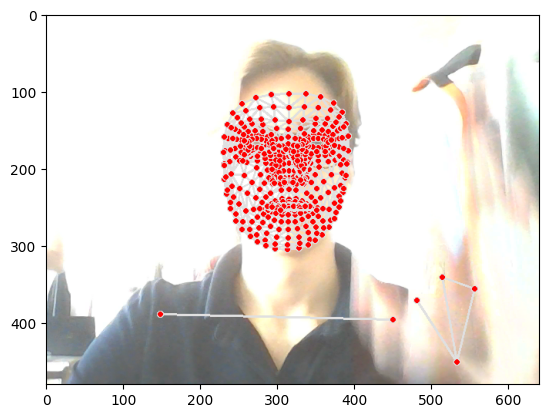

In [18]:
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [19]:
if results.left_hand_landmarks is not None:
    len(results.left_hand_landmarks.landmark)
else:
    print("No left hand detected.")
    
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

if results.face_landmarks:
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
else:
    np.zeros(1404)

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

No left hand detected.


In [20]:
result_test = extract_keypoints(results)
result_test
np.save('0', result_test)
np.load('0.npy')

array([ 0.5168218 ,  0.44878626, -1.24691749, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [21]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# 30 sequences worth of data
no_sequences = 45

# Each sequence 30 frames in length
sequence_length = 30
# Folder start
start_folder = 0

In [22]:
for action in actions:
    #dir_path = os.path.join(DATA_PATH, action)
    # if not os.path.exists(dir_path):
    #    os.makedirs(dir_path)

    # dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence))) #was str(dirmax + sequence)
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [26]:
import cv2
import time
import re

# Initialize the variable for user input
user_input = ''

cap = cv2.VideoCapture(0)

def capture_frames(p_action, p_sequence):
    for frame_num in range(sequence_length):
        v_ret, v_frame = cap.read()
        v_frame = cv2.flip(v_frame,1)
        v_image, v_results = mediapipe_detection(v_frame, holistic)
        draw_styled_landmarks(v_image, v_results)

        #Wait
        if frame_num == 0:
            cv2.putText(v_image, 'STARTING COLLECTION', (120,200),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
        cv2.putText(v_image, 'Collecting frames for {} Sequence Number {}'.format(p_action, p_sequence), (15,12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', v_image)
       # cv2.waitKey(500 if frame_num == 0 else 10)  # Display frames during the collection process

        # Display current frame number (DOESN'T WORK) Idc though
        cv2.putText(v_image, 'Frame: {}'.format(frame_num), (v_frame.shape[1] - 120, 12),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

        # Export keypoints
        keypoints = extract_keypoints(v_results)
        npy_path = os.path.join(DATA_PATH, p_action, str(p_sequence), str(frame_num))
        np.save(npy_path, keypoints)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
            
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, no_sequences):
            print(range(start_folder, no_sequences))
            while True:
                ret, frame = cap.read()
                frame = cv2.flip(frame,1)
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                cv2.putText(image, 'Next Action: {}, Sequence: {}'.format(action, sequence), (10,50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 2, cv2.LINE_AA)
                # Draw landmarks
                draw_styled_landmarks(image, results)

                cv2.imshow('OpenCV Feed', image)
                key = cv2.waitKey(10) & 0xFF
                if key == ord('g'):
                    capture_frames(action, sequence)
                    break
                elif key == ord('h'):
                    for i in range(3, 0, -1):
                        ret, frame = cap.read()
                        frame = cv2.flip(frame,1)

                        # Make detections
                        image, results = mediapipe_detection(frame, holistic)

                        # Draw landmarks
                        draw_styled_landmarks(image, results)

                        cv2.putText(image, 'Starting in {}'.format(i), (120,200),
                                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                        cv2.imshow('OpenCV Feed', image)
                        cv2.waitKey(1000)
                    capture_frames(action, sequence)
                    break
                elif key == ord('c'):
                    retake_pattern = r"([^,\s]+),\b(([0-9]|1[0-9]|2[0-9]))\b"
                    user_input = input("Enter your text: ")
                    print("User input: ", user_input)
                    match = re.search(retake_pattern, user_input)
                    if match:
                        action = match.group(1)
                        sequence = int(match.group(2))
                        for i in range(3, 0, -1):
                            ret, frame = cap.read()
                            frame = cv2.flip(frame,1)
        
                            # Make detections
                            image, results = mediapipe_detection(frame, holistic)
        
                            # Draw landmarks
                            draw_styled_landmarks(image, results)
        
                            cv2.putText(image, 'Starting in {}'.format(i), (120,200),
                                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                            cv2.imshow('OpenCV Feed', image)
                            cv2.waitKey(1000)
                        capture_frames(action, sequence)
                        break
                    else:
                        print("Invalid input. Please try again.")
                elif key == ord('q'):
                    break_flag = True
                    break

    #        if 'break_flag' in locals() and break_flag:
     #           break

    cap.release()
    cv2.destroyAllWindows()

cap.release()
cv2.destroyAllWindows()

range(0, 45)


I0000 00:00:1718348356.261680   19085 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1718348356.263628   27345 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.3-1pop1~1711635559~22.04~7a9f319), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 15.0.7, DRM 3.57, 6.8.0-76060800daily20240311-generic)


range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)
range(0, 45)


KeyboardInterrupt



# 5.1 Testing

In [6]:
import cv2
import numpy as np

def display_keypoints(file_path):
    keypoints = np.load(file_path)

    image = np.zeros((480, 640, 3), dtype=np.uint8)

    num_pose_keypoints = 33
    num_face_keypoints = 468
    num_hand_keypoints = 21

    pose_keypoints = keypoints[:num_pose_keypoints*4].reshape((-1, 4))
    face_keypoints = keypoints[num_pose_keypoints*4:num_pose_keypoints*4+num_face_keypoints*3].reshape((-1, 3))
    lh_keypoints = keypoints[num_pose_keypoints*4+num_face_keypoints*3:num_pose_keypoints*4+num_face_keypoints*3+num_hand_keypoints*3].reshape((-1, 3))
    rh_keypoints = keypoints[num_pose_keypoints*4+num_face_keypoints*3+num_hand_keypoints*3:].reshape((-1, 3))

    for keypoints in [pose_keypoints, face_keypoints, lh_keypoints, rh_keypoints]:
        for x, y, z in keypoints[:,:3]:
            cv2.circle(image, (int(x*640), int(y*480)), 5, (0, 255, 0), -1)

    cv2.imshow('Keypoints', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [8]:
import cv2
import numpy as np
import os
import time

DATA_PATH = 'MP_Data'  # Path to the directory with sequences
actions = np.array(['a','b','c'])  # Define your actions here

def display_keypoints(file_path):
    keypoints = np.load(file_path)

    image = np.zeros((480, 640, 3), dtype=np.uint8)

    num_pose_keypoints = 33
    num_face_keypoints = 468
    num_hand_keypoints = 21

    pose_keypoints = keypoints[:num_pose_keypoints*4].reshape((-1, 4))
    face_keypoints = keypoints[num_pose_keypoints*4:num_pose_keypoints*4+num_face_keypoints*3].reshape((-1, 3))
    lh_keypoints = keypoints[num_pose_keypoints*4+num_face_keypoints*3:num_pose_keypoints*4+num_face_keypoints*3+num_hand_keypoints*3].reshape((-1, 3))
    rh_keypoints = keypoints[num_pose_keypoints*4+num_face_keypoints*3+num_hand_keypoints*3:].reshape((-1, 3))

    for keypoints in [pose_keypoints, face_keypoints, lh_keypoints, rh_keypoints]:
        for x, y, z in keypoints[:,:3]:
            cv2.circle(image, (int(x*640), int(y*480)), 5, (0, 255, 0), -1)

    cv2.imshow('Keypoints', image)
    cv2.waitKey(500)
    cv2.destroyAllWindows()

# Go through all actions
for action in actions:
    action_path = os.path.join(DATA_PATH, "full", action)
    sequences = sorted(os.listdir(action_path))

    # Go through all sequences for each action
    for sequence in sequences:
        sequence_path = os.path.join(action_path, sequence)
        frames = sorted(os.listdir(sequence_path))

        # Go through all frames in each sequence
        for frame in frames:
            frame_path = os.path.join(sequence_path, frame)
            display_keypoints(frame_path)

            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

KeyboardInterrupt: 